In [ ]:
%reset -f

import os
import sys
import numpy as np
import pandas as pd

from itertools import cycle # cycle over colors on plots

# matplotlib lib to plot things
import matplotlib.pyplot as plt
from matplotlib.dates import date2num

#obspy libs
from obspy.core import read
from obspy.core import UTCDateTime
from obspy import read_inventory
from obspy import Stream, Trace
import obspy.signal
from obspy.core.util.obspy_types import ZeroSamplingRate
from obspy.io.xseed import Parser
from obspy.signal.invsim import paz_to_freq_resp

# Read channel properties files
from modules.core.aspic_channel import read_csv_panda
from modules.calibration import *

try:
    from MarsConverter import *
except:
    sys.exit("Please install Marsconverter first.")

########################################
#
#      MAIN PART
#
########################################

dataless_ELYSE = "./dataless/dataless.XB.ELYSE.seed"  # Full Sci dataless -> May be heavy to load
dataless_ELYHK = "./dataless/dataless.XB.ELYHK.seed"  # Full HK  dataless -> May be heavy to load

inv_sci = read_inventory(dataless_ELYSE)
#inv_hk  = read_inventory(dataless_ELYHK)

# Select which dataless you want to play with
inv_seed = inv_sci

## 

In [ ]:
# Don't modify this
propertiesFile = './configuration/channel.properties2.0.csv'

# read the properties file and fill a panda structure 
channel_properties_list_pd = read_csv_panda(propertiesFile, ';')

# Select the data according to the parameters
chanlist_sci = channel_properties_list_pd.loc[channel_properties_list_pd["detector"].isin(["ThermalSensor"])]
chanlist_sci.head()

In [ ]:
########################################
# INFO about channel
chan_loc = "02"
chan_name = 'BHU'
station_name = "ELYSE"

########################################
#  MarsConverter part if needed
landerproperties = '../configuration/landerconfig.xml'
mDate = MarsConverter(landerproperties)
marsDateNow = mDate.get_utc_2_lmst()
posT = marsDateNow.find('T')
#print("Today, it is ", marsDateNow, "from ", 
#      str(mDate.get_lmst_to_utc(lmst_date=int(marsDateNow[:posT]))), 
#      " UTC to ", 
#      str(mDate.get_lmst_to_utc(lmst_date=(int(marsDateNow[:posT])+1))))

########################################
# Step to get UTC from LMST time
sol = 1125

print("\n*********************")
print("Sol selected : ", sol, "from ", 
      str(mDate.get_lmst_to_utc(lmst_date=sol)), 
      " UTC to ", 
      str(mDate.get_lmst_to_utc(lmst_date=sol+1)))
print("\n*********************")
starttime_sol = str(mDate.get_lmst_to_utc(lmst_date=sol))
endtime_sol = str(mDate.get_lmst_to_utc(lmst_date=sol+1))

In [11]:
#print(inv_seed[0]._stations[0])
for sta in inv_sci[0]._stations:
    for cha in sta.channels:
        #print("channel: ", cha._code, " location: ", cha._location_code)
        if cha._code == chan_name and cha._location_code == chan_loc:
            for resp in cha.response.response_stages:
                print(resp)
                

Response type: PolesZerosResponseStage, Stage Sequence Number: 1
	XB.ELYSE.02BHU.2021.329.03.06.14 
	From M/S (VELOCITY in Meters Per Second) to V
	Stage gain: 257082.0, defined at 0.10 Hz
	Transfer function type: LAPLACE (RADIANS/SECOND)
	Normalization factor: 80.2887, Normalization frequency: 0.10 Hz
	Poles: (-46.7264+73.9273j), (-46.7264-73.9273j), (-11.7674+0j), (-0.243358+0.30515j), (-0.243358-0.30515j)
	Zeros: 0j, 0j, (-109.316+0j), (-10.1317+0j)
Response type: CoefficientsTypeResponseStage, Stage Sequence Number: 2
	From V to COUNTS
	Stage gain: 335544.0, defined at 0.00 Hz
	Decimation:
		Input Sample Rate: 500.00 Hz
		Decimation Factor: 1
		Decimation Offset: 0
		Decimation Delay: 0.00
		Decimation Correction: 0.00
	Transfer function type: DIGITAL
	Contains 0 numerators and 0 denominators
Response type: FIRResponseStage, Stage Sequence Number: 3
	XB.ELYSE.02.BHU.2021.329.03.06.14.stage_2 
	From COUNTS to COUNTS
	Stage gain: 1.0, defined at 0.00 Hz
	Decimation:
		Input Sample Ra

## Part to print the different stage of the selected channel

In [12]:
print_stage(inv_sci, station_name, chan_loc, chan_name, starttime = starttime_sol, endtime = endtime_sol)

Stages for 02  -  BHU
__________________________
Sensitivity object: 
Input units:  M/S
Output units:  COUNTS
	 stage sequence number:  1
	 +++++++++++++++++++++++++++++++++++++++++++++++++++++
Response type: PolesZerosResponseStage, Stage Sequence Number: 1
	XB.ELYSE.02BHU.2021.329.03.06.14 
	From M/S (VELOCITY in Meters Per Second) to V
	Stage gain: 257082.0, defined at 0.10 Hz
	Transfer function type: LAPLACE (RADIANS/SECOND)
	Normalization factor: 80.2887, Normalization frequency: 0.10 Hz
	Poles: (-46.7264+73.9273j), (-46.7264-73.9273j), (-11.7674+0j), (-0.243358+0.30515j), (-0.243358-0.30515j)
	Zeros: 0j, 0j, (-109.316+0j), (-10.1317+0j)
poles: [(-46.7264+73.9273j), (-46.7264-73.9273j), (-11.7674+0j), (-0.243358+0.30515j), (-0.243358-0.30515j)] 
 zeros: [0j, 0j, (-109.316+0j), (-10.1317+0j)]
	 stage sequence number:  2
	 +++++++++++++++++++++++++++++++++++++++++++++++++++++
Response type: CoefficientsTypeResponseStage, Stage Sequence Number: 2
	From V to COUNTS
	Stage gain: 335544

## Get the FIR numerators of the channel

In [13]:
# Stage Sequence Number
SSN = [2,4,5]
for S in SSN:
    FIR_Coeff = get_FIR_numerators(inv_seed, station_name, chan_name, chan_loc, S)
    print(S, FIR_Coeff)

2 []
4 []
5 []


## Plot FIR filter response

/var/folders/m8/kd1v12t913l034cjsr62x1h80000gn/T/ipykernel_2387/847821574.py:15: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20 * np.log10(abs(h)), 'b')


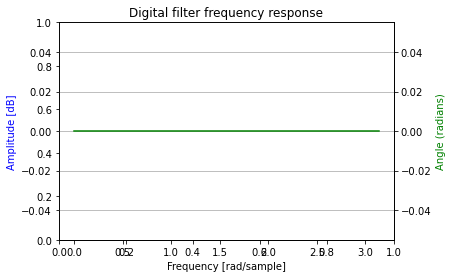

In [15]:
from scipy import signal

FIR_Coeff = get_FIR_numerators(inv_seed, station_name, chan_name, chan_loc, 2)

w, h = signal.freqz(FIR_Coeff)

import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
plt.title('Digital filter frequency response')
ax1 = fig.add_subplot(111)


plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [rad/sample]')


ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
plt.plot(w, angles, 'g')
plt.ylabel('Angle (radians)', color='g')
plt.grid()
plt.axis('tight')
plt.show()

## Get the Pole and Zeros of the channel

In [16]:
paz = []
paz = get_paz(inv_seed, chan_name, chan_loc, station_name)
if paz is not None:
    print("poles:", paz[0])
    print("poles:", paz[1])

poles: [(-46.7264+73.9273j), (-46.7264-73.9273j), (-11.7674+0j), (-0.243358+0.30515j), (-0.243358-0.30515j)]
poles: [0j, 0j, (-109.316+0j), (-10.1317+0j)]


## Get Dip and Azimuth infos

In [17]:
print(get_dip_azimuth(inv_seed, station_name, "02", "MHU"))
print(get_dip_azimuth(inv_seed, station_name, "02", "MHV"))
print(get_dip_azimuth(inv_seed, station_name, "02", "MHW"))

{'dip': '-29.4', 'azimuth': '135.1'}
{'dip': '-29.2', 'azimuth': '15.0'}
{'dip': '-29.7', 'azimuth': '255.0'}


## Plot the PAZ transfer function

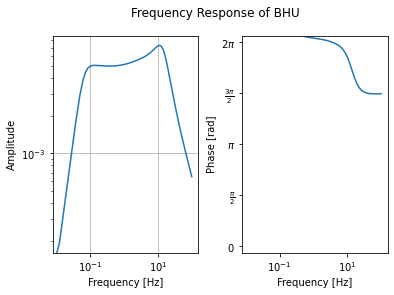

In [21]:
plot_paz(inv_seed, station_name, chan_loc, chan_name)

## Polynomial calibration

02/BHU None
Coefficients:  [  1.64830720e+05   1.97304280e-02]


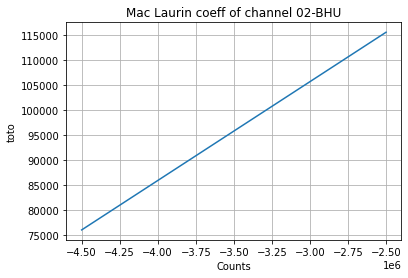

In [22]:
ytitle = "toto"
xtitle = "Counts"
title  = "Mac Laurin coeff of channel {}-{}".format(chan_loc, chan_name)

start = -4500000.
end   = -2500000.
step  = 10

coeffML = get_coeff_poly_resp_stage(inv_seed, station_name, chan_loc, chan_name, 
							  starttime=None, endtime=None)

print(f"{chan_loc}/{chan_name} {coeffML}")

coeffML = np.multiply(np.array([6.1504, 7.3621e-7]), 2.68e+4)
#coeffML = np.multiply(np.array([1.]), 2.68e+2)

if coeffML is not None and len(coeffML)>0: 
    print("Coefficients: ", coeffML)

# Plot of the polynomial function
if coeffML is not None and len(coeffML)>0: 
    plot_maclaurin(coeffML, start, end, step, xtitle, ytitle, title)
else:
    print("It seems, there is no Polynomial coef for {}-{}".format(chan_loc, chan_name))

## To plot the transfer function

In [24]:
#figs, axs = plot_responses(inv_seed, channel_list, output, min_freq)
#plt.show()

NameError: name 'channel_list' is not defined